## Text Classification-sentiment analysis
Twitter Data
- Concept of validation set
- Overfitting
- L2 Regularization and Dropout Regularization
- Transfer learning

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import re
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
#Load the dataset
train_data=pd.read_csv('sentiment_dataset/train.csv')
test_data=pd.read_csv('sentiment_dataset/test.csv')

In [ ]:
#Remove null values from each row
train_data.dropna(axis=0,how='any',inplace=True)
test_data.dropna(axis=0,how='any',inplace=True)

In [ ]:
train_data.head()

,textID,text,selected_text,sentiment,num_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


### Data Preprocessing

In [ ]:
#Remove rows with less than 3 words
train_data['num_words']=train_data['text'].apply(lambda x: len(str(x).split()))
mask=train_data['num_words']>2
train_data=train_data[mask]

test_data['num_words']=test_data['text'].apply(lambda x: len(str(x).split()))
mask=test_data['num_words']>2
test_data=test_data[mask]

In [ ]:
#Pre-processing: Remove emoji's,flags, symbols, urls,digits, special characters, etc.
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(text))

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string


def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = str(text).translate(table)
    #print('cleaned:'+text1)
    textArr= str(text1).split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()



In [ ]:
#Applying pre-processing functions of training and test data
train_data['text']=train_data['text'].apply(remove_emoji)
train_data['text']=train_data['text'].apply(remove_url)
train_data['text']=train_data['text'].apply(clean_text)

test_data['text']=test_data['text'].apply(remove_emoji)
test_data['text']=test_data['text'].apply(remove_url)
test_data['text']=test_data['text'].apply(clean_text)


In [ ]:
#Splitting training data into train and validation set
train_x,valid_x,train_y,valid_y=train_test_split(train_data['text'].tolist(),\
    train_data['sentiment'].tolist(),\
        random_state=0,test_size=0.33,\
        stratify=train_data['sentiment'].tolist())

In [ ]:
#Converting sentiments to numerical labels and then applying categorical encoding
le=LabelEncoder()
train_y=le.fit_transform(train_y)
train_y=keras.utils.to_categorical(train_y)
train_y[:1]
valid_y=le.transform(valid_y)
valid_y=keras.utils.to_categorical(valid_y)

test_y=le.transform(test_data['sentiment'].tolist())
test_y=keras.utils.to_categorical(test_y)

In [ ]:
train_x=np.array(train_x)
valid_x=np.array(valid_x)
test_x=np.array(test_data['text'].tolist())

### Training NN with pre-trained 20 dim word embedding

In [ ]:
#Converting x and y arrays into tensor datasets
train_ds=tf.data.Dataset.from_tensor_slices((train_x,train_y))
valid_ds=tf.data.Dataset.from_tensor_slices((valid_x,valid_y))
test_ds=tf.data.Dataset.from_tensor_slices((test_x,test_y))

In [ ]:
#Importing pre-trained word vectors from tensorflow hub
embedding='https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'
hub_layer=hub.KerasLayer(embedding,trainable=True,input_shape=[],dtype=tf.string)

In [ ]:
print(train_x[0])

just getting additional free


In [ ]:
hub_layer(train_x[:1])

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.02252544, -1.102936  , -0.45312536,  1.1712923 , -0.9280152 ,
        -1.6799717 , -0.03097978, -0.04522766, -0.69689393, -0.3546787 ,
        -0.9819268 ,  1.3606595 , -0.7599448 ,  0.05979407, -0.71509284,
         0.48663723,  1.3430784 , -1.0147772 ,  0.13958323, -0.14541228]],
      dtype=float32)>

In [ ]:
#Create a sequential Neural Network
model=keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(3,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile model-define loss function, accuracy, optimizer
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['CategoricalAccuracy'],
              optimizer='adam')

In [ ]:
#Training neural network
history=model.fit(train_ds.batch(128),
          epochs=20,
          validation_data=valid_ds.batch(128))

Epoch 1/20


c:\Users\AARUSH\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


141/141 [==============================] - 2s 7ms/step - loss: 1.2528 - categorical_accuracy: 0.3327 - val_loss: 1.0911 - val_categorical_accuracy: 0.4165
Epoch 2/20
141/141 [==============================] - 1s 5ms/step - loss: 1.0610 - categorical_accuracy: 0.4583 - val_loss: 1.0059 - val_categorical_accuracy: 0.5112
Epoch 3/20
141/141 [==============================] - 1s 5ms/step - loss: 0.9763 - categorical_accuracy: 0.5380 - val_loss: 0.9384 - val_categorical_accuracy: 0.5610
Epoch 4/20
141/141 [==============================] - 1s 5ms/step - loss: 0.9011 - categorical_accuracy: 0.5888 - val_loss: 0.8882 - val_categorical_accuracy: 0.5902
Epoch 5/20
141/141 [==============================] - 1s 6ms/step - loss: 0.8390 - categorical_accuracy: 0.6261 - val_loss: 0.8540 - val_categorical_accuracy: 0.6145
Epoch 6/20
141/141 [==============================] - 1s 5ms/step - loss: 0.7895 - categorical_accuracy: 0.6523 - val_loss: 0.8314 - val_categorical_accuracy: 0.6244
Epoch 7/20
141/

Best Validation Loss: 0.8059 
Best Validation Accuracy: 0.6507


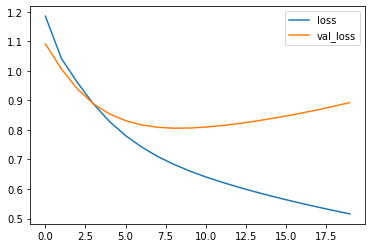

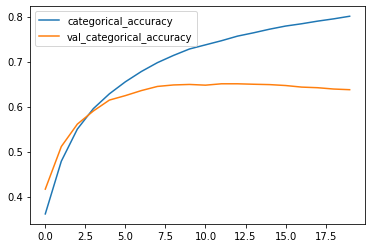

In [ ]:
#ploting training and validation loss
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f} \nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [ ]:
#Testing the model on test data
model.evaluate(test_ds.batch(128))

27/27 [==============================] - 0s 2ms/step - loss: 1.4401 - categorical_accuracy: 0.6209


[1.440144419670105, 0.6208503246307373]

### The model is overfitting so we apply L2 regularization

In [ ]:
#Handling overfitting using dropout, L2 regularization
model1=keras.Sequential()
model1.add(hub_layer)
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(10,activation='relu',kernel_regularizer=keras.regularizers.l2(0.05)))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(3,activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.05)))


In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics=['CategoricalAccuracy'],
               optimizer='adam')

In [ ]:
history1=model1.fit(train_ds.shuffle(1000).batch(128),
          epochs=60,
          validation_data=valid_ds.batch(128))

Epoch 1/60


c:\Users\AARUSH\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


141/141 [==============================] - 2s 7ms/step - loss: 2.2513 - categorical_accuracy: 0.3172 - val_loss: 1.5795 - val_categorical_accuracy: 0.3735
Epoch 2/60
141/141 [==============================] - 1s 6ms/step - loss: 1.5512 - categorical_accuracy: 0.3641 - val_loss: 1.3269 - val_categorical_accuracy: 0.3970
Epoch 3/60
141/141 [==============================] - 1s 6ms/step - loss: 1.3005 - categorical_accuracy: 0.3926 - val_loss: 1.1882 - val_categorical_accuracy: 0.4024
Epoch 4/60
141/141 [==============================] - 1s 6ms/step - loss: 1.1735 - categorical_accuracy: 0.4285 - val_loss: 1.1048 - val_categorical_accuracy: 0.4647
Epoch 5/60
141/141 [==============================] - 1s 6ms/step - loss: 1.1047 - categorical_accuracy: 0.4778 - val_loss: 1.0594 - val_categorical_accuracy: 0.5344
Epoch 6/60
141/141 [==============================] - 1s 6ms/step - loss: 1.0683 - categorical_accuracy: 0.5078 - val_loss: 1.0312 - val_categorical_accuracy: 0.5691
Epoch 7/60
141/

Best Validation Loss: 0.8736 
Best Validation Accuracy: 0.6634


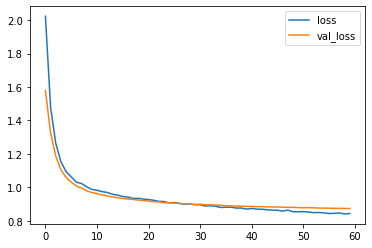

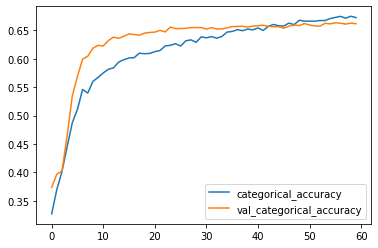

In [ ]:
#ploting training and validation loss
history_df = pd.DataFrame(history1.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f} \nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [ ]:
#Testing the model on test data
model1.evaluate(test_ds.batch(128))

27/27 [==============================] - 0s 2ms/step - loss: 0.8601 - categorical_accuracy: 0.6715


[0.8601452708244324, 0.6715201139450073]

### Using 128 dim word embedding
this file was ran on Kaggle

In [10]:
embedding='https://tfhub.dev/google/nnlm-en-dim128/2'
hub_layer=hub.KerasLayer(embedding,input_shape=[],dtype=tf.string)

2022-04-30 20:24:17.082850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
hub_layer(train_x[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.30171746,  0.11441445,  0.04430154,  0.15805684,  0.00932129,
        -0.01273593, -0.03146448, -0.09147067,  0.01436323,  0.10752429,
        -0.15413314, -0.03710237, -0.1014939 , -0.03022293, -0.0669625 ,
        -0.10535901, -0.02786255, -0.09795634, -0.24064359,  0.10665305,
         0.2232809 , -0.08729829, -0.04989024,  0.03768301, -0.11618403,
        -0.05657186,  0.2260302 ,  0.0128693 , -0.11821792, -0.02930259,
         0.04772896,  0.02752521, -0.01438598,  0.20336376,  0.1006204 ,
         0.03451556, -0.07738236,  0.01930993,  0.09256567,  0.07220806,
         0.00258796, -0.09761407,  0.11032079,  0.01587577, -0.09081273,
         0.1393445 , -0.00683034,  0.03532982,  0.02565479, -0.16792788,
        -0.02380151, -0.00501589,  0.08929241, -0.05368774, -0.02739222,
         0.0621828 , -0.16751455, -0.09210834,  0.10788223, -0.11234299,
         0.07741679,  0.1305575 ,  0.02184896, -0.13060962, -0.12497135,
 

In [12]:
model=keras.Sequential()
model.add(hub_layer)
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(3,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 124,651,139
Trainable params: 8,451
Non-trainable params: 124,642,688
_________________________________________________________________


In [14]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['CategoricalAccuracy'],
              optimizer='adam')

In [15]:
history=model.fit(train_ds.shuffle(10000).batch(512),
          epochs=60,
          validation_data=valid_ds.batch(512))

Epoch 1/60


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


36/36 [==============================] - 2s 10ms/step - loss: 1.0473 - categorical_accuracy: 0.4785 - val_loss: 0.9868 - val_categorical_accuracy: 0.5711
Epoch 2/60
36/36 [==============================] - 0s 6ms/step - loss: 0.9479 - categorical_accuracy: 0.5863 - val_loss: 0.9058 - val_categorical_accuracy: 0.6003
Epoch 3/60
36/36 [==============================] - 0s 6ms/step - loss: 0.8881 - categorical_accuracy: 0.6039 - val_loss: 0.8659 - val_categorical_accuracy: 0.6173
Epoch 4/60
36/36 [==============================] - 0s 6ms/step - loss: 0.8610 - categorical_accuracy: 0.6193 - val_loss: 0.8508 - val_categorical_accuracy: 0.6214
Epoch 5/60
36/36 [==============================] - 0s 6ms/step - loss: 0.8458 - categorical_accuracy: 0.6265 - val_loss: 0.8383 - val_categorical_accuracy: 0.6288
Epoch 6/60
36/36 [==============================] - 0s 6ms/step - loss: 0.8364 - categorical_accuracy: 0.6308 - val_loss: 0.8314 - val_categorical_accuracy: 0.6323
Epoch 7/60
36/36 [========

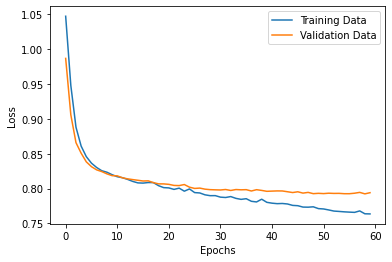

In [16]:
plt.plot(history.history['loss'],label='Training Data')
plt.plot(history.history['val_loss'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

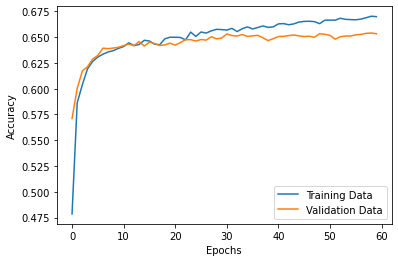

In [17]:
plt.plot(history.history['categorical_accuracy'],label='Training Data')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
model.evaluate(test_ds.batch(512),verbose=2)

7/7 - 0s - loss: 0.7781 - categorical_accuracy: 0.6581


[0.7780953049659729, 0.6581246256828308]